In [31]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [32]:
df = pd.read_csv('df_combine.csv')
df.head(100)

,Date,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,unemploy_rate_us,unemploy_rate_vn,fdi_vn,fdi_us
0,2018-01-01,22625.0,22655.0,22735.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
1,2018-01-02,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2,2018-01-03,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
3,2018-01-04,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
4,2018-01-05,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
...,...,...,...,...,...,...,...,...,...,...
95,2018-04-06,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
96,2018-04-07,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
97,2018-04-08,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
98,2018-04-09,22725.0,22755.0,22825.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9


In [33]:
df['Date'] = dates = pd.to_datetime(df['Date'])
df = df.dropna(how='any',axis=0) 
# df.index = pd.to_datetime(df['Date'])
cols_name = list(df)[1:len(df)]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 2189
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2190 non-null   datetime64[ns]
 1   Buy Cash           2190 non-null   float64       
 2   Buy Transfer       2190 non-null   float64       
 3   Sell               2190 non-null   float64       
 4   inflation_rate_vn  2190 non-null   float64       
 5   inflation_rate_us  2190 non-null   float64       
 6   unemploy_rate_us   2190 non-null   float64       
 7   unemploy_rate_vn   2190 non-null   float64       
 8   fdi_vn             2190 non-null   float64       
 9   fdi_us             2190 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 188.2 KB


In [35]:
df_for_training = df[cols_name].astype(float)
df_for_training.head(100)

,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,unemploy_rate_us,unemploy_rate_vn,fdi_vn,fdi_us
0,22625.0,22655.0,22735.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
1,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
3,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
4,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
...,...,...,...,...,...,...,...,...,...
95,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
96,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
97,22735.0,22765.0,22835.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9
98,22725.0,22755.0,22825.0,0.0275,0.025,0.039333,0.0220,6.740000,53.9


In [71]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [72]:
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  prediction_copies = np.repeat(predictions, df_for_training.shape[1], axis=-1)
  predictions = scaler.inverse_transform(prediction_copies)[:,0].flatten()
  y_copies = np.repeat(y, df_for_training.shape[1], axis=-1)
  y = scaler.inverse_transform(y_copies)[:,0].flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions')
  plt.plot(df['Actuals'][start:end], label = 'Actuals')
  plt.legend()
  return df

In [73]:
trainX = []
trainY = []
n_future = 1  
n_past = 14

In [74]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 2])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape: {}.'.format(trainX.shape))
print('trainY shape: {}.'.format(trainY.shape))

trainX shape: (2176, 14, 9).
trainY shape: (2176, 1).


In [75]:
x_train = trainX[:2000]
x_test = trainX[2000:]
y_train = trainY[:2000]
y_test = trainY[2000:]


In [87]:
model = Sequential()
model.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model.add(LSTM(64))
# model.add(Dense(16, 'relu'))
model.add(Dense(8, 'relu'))
model.add(Dense(4, 'relu'))
model.add(Dense(1, 'linear'))

In [88]:
cp4 = ModelCheckpoint('model3.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [89]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=1024, validation_split=0.1, verbose=1,callbacks=[cp4])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - loss: 0.7184 - mean_absolute_error: 0.5559 - mean_squared_error: 0.7184 - val_loss: 0.8580 - val_mean_absolute_error: 0.8816 - val_mean_squared_error: 0.8580
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.7003 - mean_absolute_error: 0.5477 - mean_squared_error: 0.7003 - val_loss: 0.8438 - val_mean_absolute_error: 0.8743 - val_mean_squared_error: 0.8438
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.6711 - mean_absolute_error: 0.5336 - mean_squared_error: 0.6711 - val_loss: 0.8301 - val_mean_absolute_error: 0.8673 - val_mean_squared_error: 0.8301
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6632 - mean_absolute_error: 0.5262 - mean_squared_error: 0.6632 - val_loss: 0.8167 - val_mean_absolute_error: 0.8603 - val_mean_squared_error: 0.8167
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6450 - mean_absolute_error: 0.5173 - mean_squared_error: 0.6450 - val_loss: 0.8035 - val_mean_

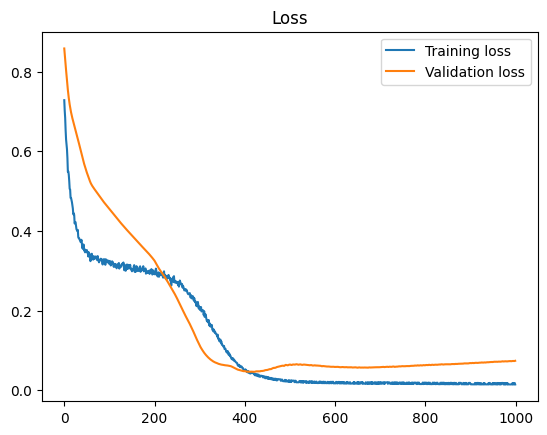

In [90]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.legend()

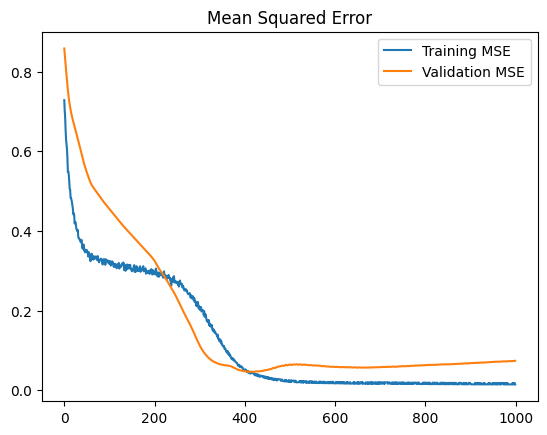

In [91]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.legend()

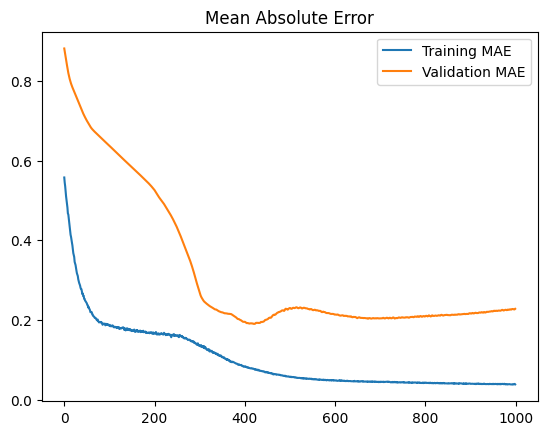

In [92]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.legend()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


,Predictions,Actuals
0,23429.720703,23541.099666
1,23421.912109,23550.109233
2,23420.300781,23586.147500
3,23435.232422,23577.137933
4,23442.457031,23545.604450
...,...,...
171,23633.626953,24144.740637
172,23646.000000,24072.664103
173,23625.761719,24090.683237
174,23617.080078,24090.683237


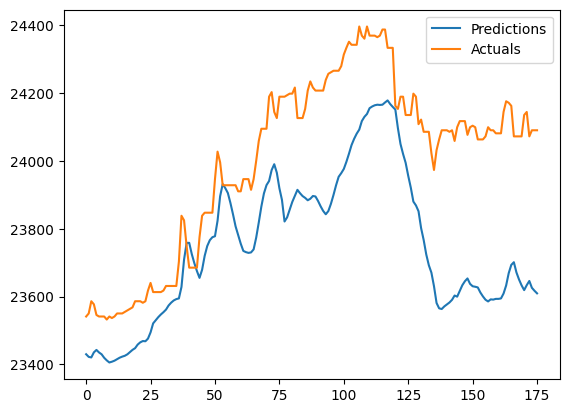

In [93]:
plot_predictions1(model, x_test, y_test, end=len(y_test))